In [1]:
# allows to import own functions
import sys, os, re
root_project = re.findall(r'(^\S*TFM-master)', os.getcwd())[0]
sys.path.append(root_project)


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import PercentFormatter
from src.models.sird_model import SIRD_model
from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform, expon, randint, truncexpon

sns.set()
%matplotlib inline

In [2]:
# Features to keep
dict_keys = [
    'i_country',
    'idx_country',
    'simulation_time',
    'R0',
    'Tc',
    'Tr',
    'omega',
    'inf_pow_1',
    'inf_pow_2',
    'mort_pow_1',
    'mort_pow_2',
    'mort_pow_3',
    'n_closed',
    'react_time',
    'total_infected',
    'total_deceased',
    'total_recovered',
    'new_infected_world_t',
    'new_recovered_world_t',
    'new_deceased_world_t',
    'new_infected_t',
    'new_recovered_t',
    'new_deceased_t',
    'SIRD_t',
    'SIRD_p_t',
    'SIRD_world_t',
    'SIRD_world_p_t'
]


df_countries = pd.read_pickle(
    f"{root_project}/data/interim/country_info_final.pickle")

# Paramater space to explore
# In uniform distribution if max value desired is X, scale=X-loc
# In randint distribution if max value desired is X, high=X+low
R0 = uniform(loc=2, scale=18) 
Tr = uniform(loc=2, scale=28)
omega = truncexpon(loc=0.01, b=1-0.01) # Exponential truncated to maximum value b
n_closed = randint(low=0, high=20)
react_time = randint(low=1, high=31)
countries = list(df_countries['country_code'].values) # All countries in df

param_grid = {'R0' : R0,
              'Tr' : Tr,
              'omega' : omega,
              # 'limit_deceased' : limit_deceased,
              'n_closed' : n_closed,
              'react_time' : react_time,
              'countries' : countries }

n_simulations = 1 # specify the number of simulations to make
param_list = list(ParameterSampler(param_grid, n_iter=n_simulations))


# param_list = [{'R0': 9.751350134142209,
#   'Tr': 3.5927354526680837,
#   'countries': 'SUR',
#   'n_closed': 12,
#   'omega': 0.42533615051658685,
#   'react_time': 29}]


param_list = [{'R0': 5,
  'Tr': 30,
  'countries': 'ESP',
  'n_closed': 0,
  'omega': 0.01,
  'react_time': 5}]


In [3]:
for simulation in param_list:
    sir_model = SIRD_model(
        simulation['R0'],
        simulation['Tr'],
        simulation['omega'],
        simulation['countries'],
        simulation['n_closed'],
        simulation['react_time'])
    sir_model.simulate()
    sir_model.compute_disease_features()
    data = sir_model.get_simulation_data() # Get the data in a dict
    subset_data = {column: data[column] for column in dict_keys}




##########################3
# R0 = 3.139940
# Tr = 22.677001
# omega = 0.7
# # limit_deceased = 181
# n_closed = 6
# react_time = 10
# i_country = 'PYF'

# sir_model = SIRD_model(R0, Tr, omega, i_country, n_closed, react_time)
# sir_model.simulate()
# sir_model.compute_disease_features()
# data = sir_model.get_simulation_data() # Get the data in a dict
# subset_data = {column: data[column] for column in dict_keys}
#################################


s = pd.Series(subset_data)
s

i_country                                                              ESP
idx_country                                                            170
simulation_time                                                        730
R0                                                                       5
Tc                                                                       6
Tr                                                                      30
omega                                                                 0.01
inf_pow_1                                                          40.9286
inf_pow_2                                                          4.11966
mort_pow_1                                                       0.0488656
mort_pow_2                                                       0.0580913
mort_pow_3                                                        0.215385
n_closed                                                                 0
react_time               

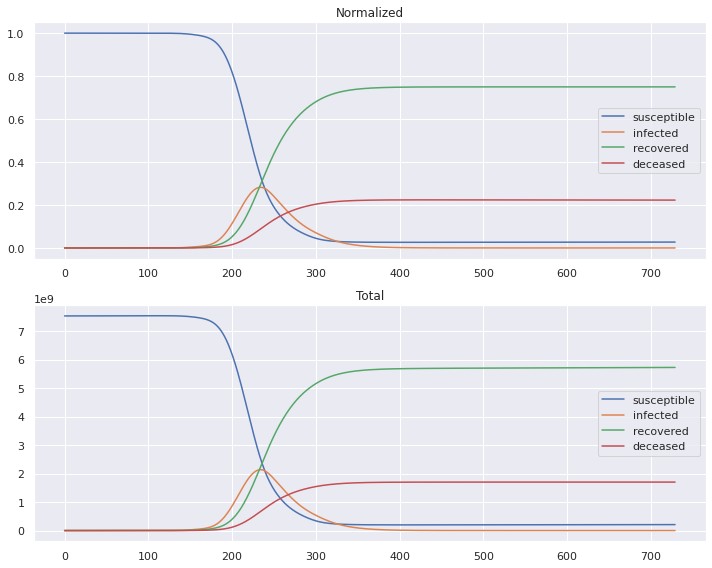

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(s['SIRD_world_p_t'][0, :], label='susceptible')
ax[0].plot(s['SIRD_world_p_t'][1, :], label='infected')
ax[0].plot(s['SIRD_world_p_t'][2, :], label='recovered')
ax[0].plot(s['SIRD_world_p_t'][3, :], label='deceased')
ax[0].set_title('Normalized')
ax[0].legend()
ax[1].plot(s['SIRD_world_t'][0, :], label='susceptible')
ax[1].plot(s['SIRD_world_t'][1, :], label='infected')
ax[1].plot(s['SIRD_world_t'][2, :], label='recovered')
ax[1].plot(s['SIRD_world_t'][3, :], label='deceased')
ax[1].set_title('Total')
ax[1].legend()
plt.tight_layout()

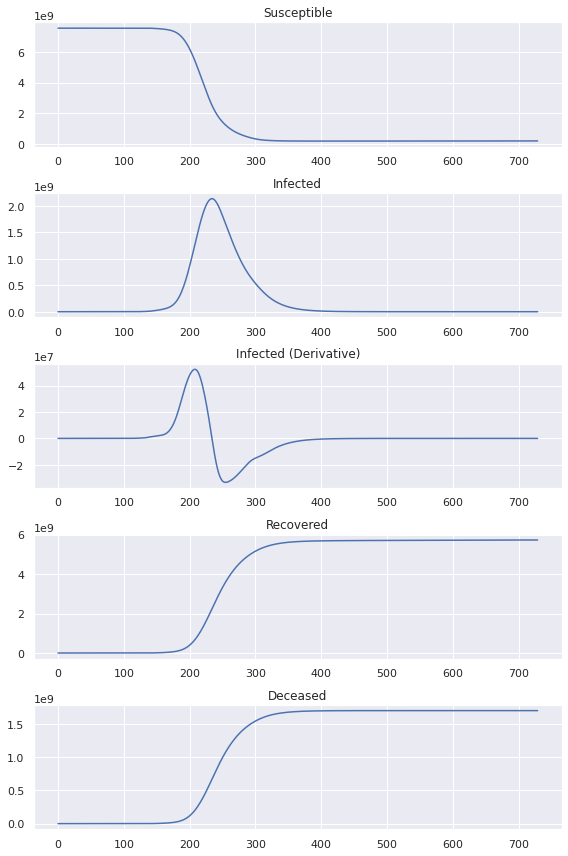

In [5]:
# los tres grupos en detalle en el instante t
fig, ax = plt.subplots(5, 1, figsize=(8, 12))
ax[0].plot(s['SIRD_world_t'][0, :])
ax[0].set_title('Susceptible')
ax[1].plot(s['SIRD_world_t'][1, :])
ax[1].set_title('Infected')
ax[2].plot(np.gradient(s['SIRD_world_t'][1, :]))
ax[2].set_title('Infected (Derivative)')
ax[3].plot(s['SIRD_world_t'][2, :])
ax[3].set_title('Recovered')
ax[4].plot(s['SIRD_world_t'][3, :])
ax[4].set_title('Deceased')
plt.tight_layout()

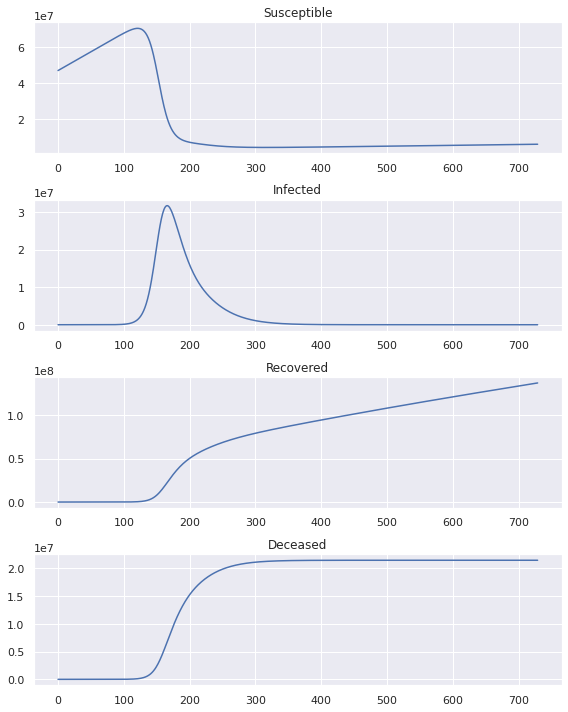

In [6]:
# los tres grupos en detalle en el instante t para el pais de inicio
fig, ax = plt.subplots(4, 1, figsize=(8, 10))
ax[0].plot(s['SIRD_t'][s['idx_country'], 0, :])
ax[0].set_title('Susceptible')
ax[1].plot(s['SIRD_t'][s['idx_country'], 1, :])
ax[1].set_title('Infected')
ax[2].plot(s['SIRD_t'][s['idx_country'], 2, :])
ax[2].set_title('Recovered')
ax[3].plot(s['SIRD_t'][s['idx_country'], 3, :])
ax[3].set_title('Deceased')
plt.tight_layout()

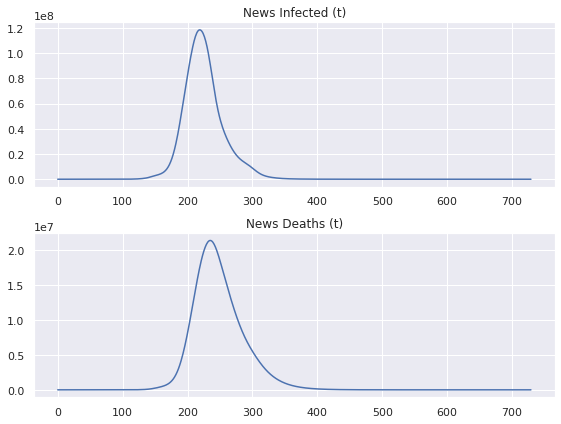

In [7]:
# nuevos infectados y muertos en el instante t
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(s['new_infected_world_t'])
ax[0].set_title('News Infected (t)')
ax[1].plot(s['new_deceased_world_t'])
ax[1].set_title('News Deaths (t)')
plt.tight_layout()

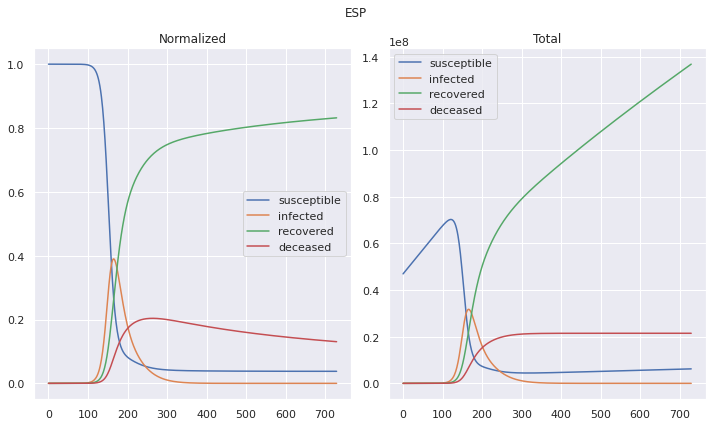

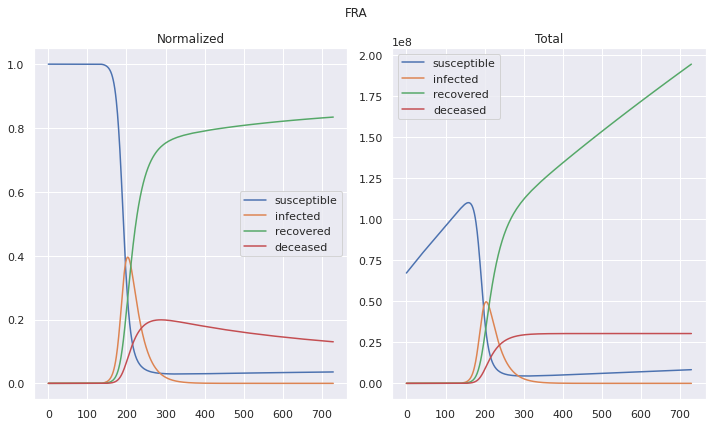

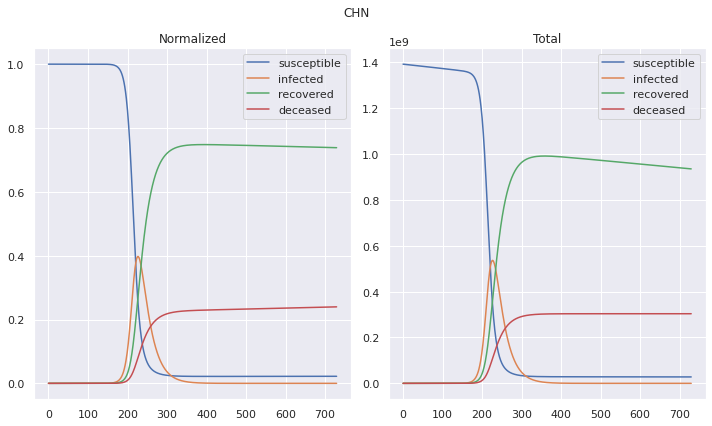

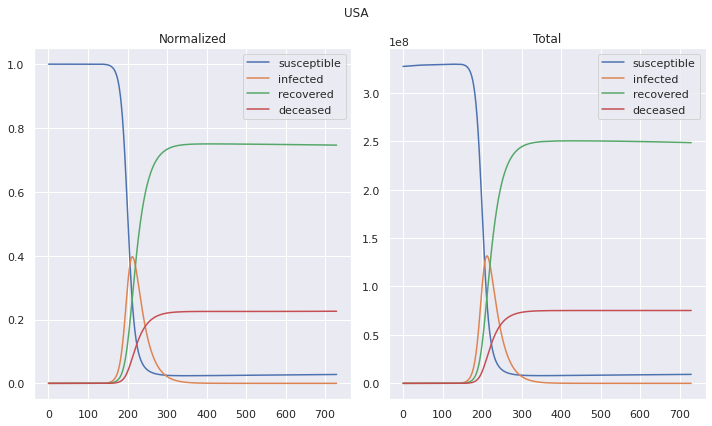

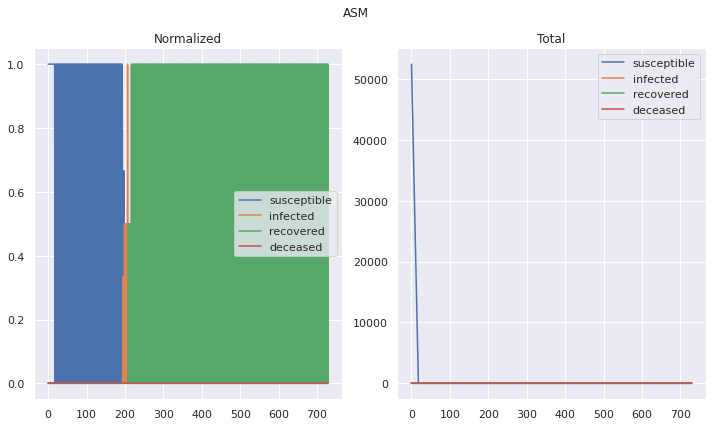

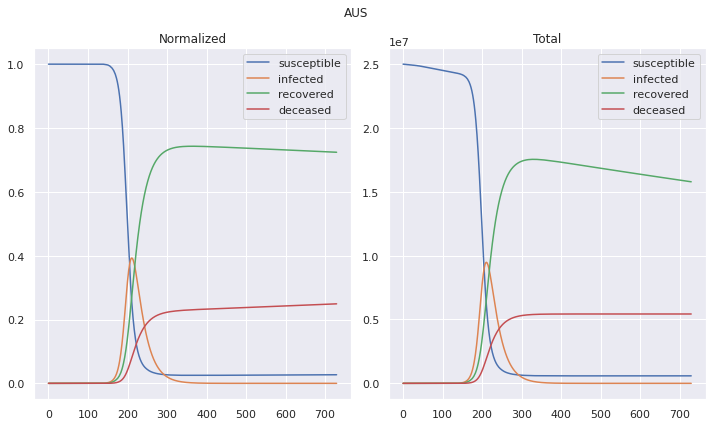

In [8]:
df_countries = pd.read_pickle(
    f"{root_project}/data/interim/country_info_final.pickle")

countries = [s['i_country'], 'FRA', 'CHN', 'USA', 'ASM', 'AUS']
idx = []

for country in countries:
    index = df_countries.loc[df_countries["country_code"]
                             == country].index.item()
    idx.append(index)

# idx = [168, 39]  # introduce los indices de los paises a consultar

for i, country in zip(idx, countries):
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax[0].plot(s['SIRD_p_t'][i, 0, :], label='susceptible')
    ax[0].plot(s['SIRD_p_t'][i, 1, :], label='infected')
    ax[0].plot(s['SIRD_p_t'][i, 2, :], label='recovered')
    ax[0].plot(s['SIRD_p_t'][i, 3, :], label='deceased')

    ax[0].set_title('Normalized')
    ax[0].legend()
    ax[1].plot(s['SIRD_t'][i, 0, :], label='susceptible')
    ax[1].plot(s['SIRD_t'][i, 1, :], label='infected')
    ax[1].plot(s['SIRD_t'][i, 2, :], label='recovered')
    ax[1].plot(s['SIRD_t'][i, 3, :], label='deceased')
    ax[1].set_title('Total')
    ax[1].legend()
    fig.suptitle(country)
    plt.tight_layout()

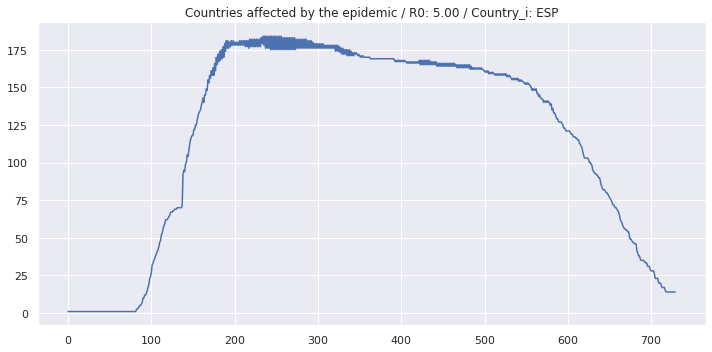

In [9]:
# para ver como evolucionan los paises afectados
affected = []
# for t in range(20,SIR_ncountry_t.shape[2]):
for t in range(s['simulation_time']):
    idx = np.argwhere(s['SIRD_t'][:, 1, t] > 0.99)
    countries = set(df_countries.iloc[idx.flatten().tolist(), 0].values)
    #print('Day {} ->'.format(t), 'Cuntries affected: {}'.format(len(countries)))
    affected.append(len(countries))


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(affected)
plt.title(
    'Countries affected by the epidemic / R0: {:.2f} / Country_i: {}'.format(s['R0'], s['i_country']))
plt.tight_layout()